**Tele user churn prediction -- supervised learning**

dataset: churn // Now it's been purchased by HP

Set up the environment

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.2MB/s 


reading dataset

In [0]:
file = drive.CreateFile({'id':'1fW5vmzlBEfNfEBMQnUfhAy6g4HMcttr5'}) 
file.GetContentFile('churn.all')

my_data = pd.read_csv('churn.all')

In [0]:
# view row data
my_data.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [0]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null object
intl_plan                        5000 non-null object
voice_mail_plan                  5000 non-null object
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes           

# Step1: Data cleaning

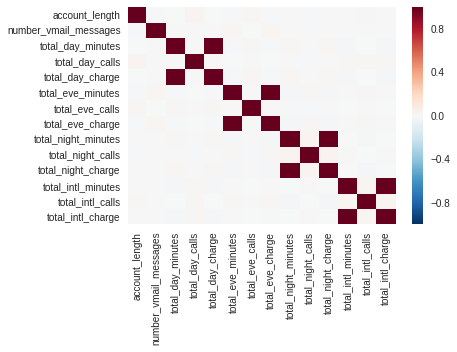

In [0]:
churn_all = my_data

# clean str

churn_all['voice_mail_plan'] = churn_all['voice_mail_plan'].map(lambda x: x.strip())
churn_all['intl_plan'] = churn_all['intl_plan'].map(lambda x: x.strip())
churn_all['churned'] = churn_all['churned'].map(lambda x: x.strip())

features = ["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_night_charge", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]
# correlations between all the features
corr = churn_all[features].corr()

# show heapmap of correlations
sns.heatmap(corr)

In [0]:
churn_all['churned'] = churn_all['churned'] == 'True.'

yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_all[yes_no_cols] = churn_all[yes_no_cols] == 'yes'

to_drop = ['area_code','phone_number', 'state']
high_corr = ['total_eve_minutes', 'total_day_minutes', 'total_intl_calls', 'total_night_minutes']

churn_feat = churn_all.drop(to_drop, axis = 1).drop(high_corr, axis = 1)

In [0]:
churn_feat.head(5)

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_minutes,total_intl_charge,number_customer_service_calls,churned
0,128,False,True,25,110,45.07,99,16.78,91,11.01,10.0,2.70,1,False
1,107,False,True,26,123,27.47,103,16.62,103,11.45,13.7,3.70,1,False
2,137,False,False,0,114,41.38,110,10.30,104,7.32,12.2,3.29,0,False
3,84,True,False,0,71,50.90,88,5.26,89,8.86,6.6,1.78,2,False
4,75,True,False,0,113,28.34,122,12.61,121,8.41,10.1,2.73,3,False


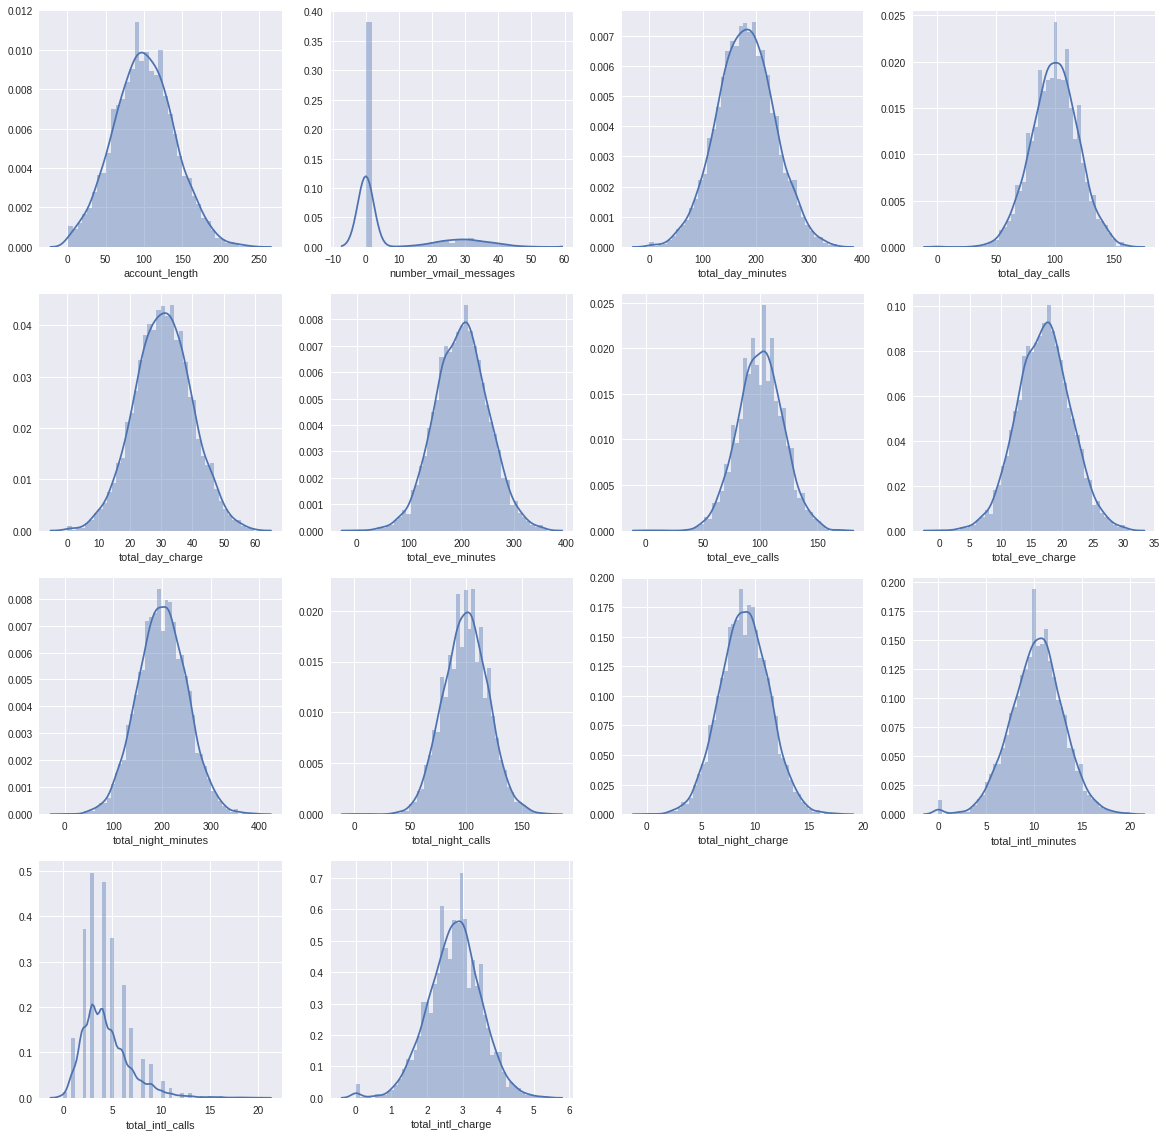

In [0]:
nrow = 4
ncol = 4
plt.figure(figsize=(20,20))
for i in range(len(features)):
  plt.subplot(nrow, ncol, i + 1)
  sns.distplot(churn_all[features[i]])
  

# Step2: Training model


In [0]:
y = np.where(churn_feat['churned'] == True, 1, 0)

X = churn_feat.drop(['churned'], axis = 1)

In [0]:
X.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_minutes,total_intl_charge,number_customer_service_calls
0,128,False,True,25,110,45.07,99,16.78,91,11.01,10.0,2.70,1
1,107,False,True,26,123,27.47,103,16.62,103,11.45,13.7,3.70,1
2,137,False,False,0,114,41.38,110,10.30,104,7.32,12.2,3.29,0
3,84,True,False,0,71,50.90,88,5.26,89,8.86,6.6,1.78,2
4,75,True,False,0,113,28.34,122,12.61,121,8.41,10.1,2.73,3


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))
print (pd.DataFrame(X).head())

Feature space holds 5000 observations and 13 features
Unique target labels: [0 1]
         0         1         2         3         4         5         6   \
0  0.698941 -0.323240  1.667120  1.273145  0.502824  1.574074 -0.060077   
1  0.169849 -0.323240  1.667120  1.346973  1.158422 -0.347082  0.141693   
2  0.925695 -0.323240 -0.599837 -0.572549  0.704546  1.171286  0.494791   
3 -0.409634  3.093675 -0.599837 -0.572549 -1.463971  2.210457 -0.614946   
4 -0.636388  3.093675 -0.599837 -0.572549  0.654116 -0.252115  1.100103   

         7         8         9         10        11        12  
0 -0.063849 -0.446928  0.876286 -0.094809 -0.095509 -0.436676  
1 -0.101089  0.154374  1.069818  1.245227  1.245982 -0.436676  
2 -1.572084  0.204483 -0.746737  0.701969  0.695971 -1.202236  
3 -2.745155 -0.547145 -0.069377 -1.326194 -1.329681  0.328885  
4 -1.034426  1.056327 -0.267307 -0.058592 -0.055264  1.094445  


In [0]:
X

array([[ 0.69894149, -0.32324017,  1.66712012, ..., -0.09480937,
        -0.0955088 , -0.43667564],
       [ 0.16984882, -0.32324017,  1.66712012, ...,  1.24522677,
         1.24598231, -0.43667564],
       [ 0.92569549, -0.32324017, -0.5998368 , ...,  0.70196888,
         0.69597096, -1.20223603],
       ...,
       [-0.98911606, -0.32324017, -0.5998368 , ...,  1.20900958,
         1.20573758, -0.43667564],
       [ 0.2202386 , -0.32324017, -0.5998368 , ..., -0.63806726,
        -0.63210525, -1.20223603],
       [-0.35924384, -0.32324017,  1.66712012, ..., -0.34832972,
        -0.35039211, -1.20223603]])

In [0]:
# split data into test and training
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 4000 observation with 13 features
test data has 1000 observation with 13 features


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier()

# SVC
classifier_SVC = SVC()

In [0]:
models = {"Logistic Reg": classifier_logistic,
          "KNN": classifier_KNN,
          "Random Forest": classifier_RF,
          "SVC": classifier_SVC }

for model in models.keys():
  models[model].fit(X_train, y_train)

In [0]:
for model in models.keys():
  score = models[model].score(X_test, y_test)
  print(model, "has an acurracy of", score)

Logistic Reg has an acurracy of 0.861
KNN has an acurracy of 0.904
Random Forest has an acurracy of 0.939
SVC has an acurracy of 0.926


In [0]:
for model in models.keys():
    cv_score = model_selection.cross_val_score(models[model], X, y, cv=5)
    print('Model accuracy of %s is: %.3f via cross validation'%(model,cv_score.mean()))

Model accuracy of Logistic Reg is: 0.864 via cross validation
Model accuracy of KNN is: 0.893 via cross validation
Model accuracy of Random Forest is: 0.928 via cross validation
Model accuracy of SVC is: 0.919 via cross validation


# Step3: test hyperparameters

In [0]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))


In [0]:
# Logi reg

parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print_grid_search_metrics(Grid_LR)
best_LR_model = Grid_LR.best_estimator_
print(best_LR_model.score(X_test, y_test), "is the prediction result")

Best score: 0.866
Best parameters set:
	C: 1
	penalty: 'l1'
0.862 is the prediction result


In [0]:
#KNN

parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [3, 5, 7, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [0]:
print_grid_search_metrics(Grid_KNN)
best_KNN_model = Grid_KNN.best_estimator_
print(best_KNN_model.score(X_test, y_test), "is the prediction result")

Best score: 0.888
Best parameters set:
	n_neighbors: 7
0.905 is the prediction result


In [0]:
# RF
parameters = {
    'n_estimators' : [40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [40, 60, 80]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [0]:
print_grid_search_metrics(Grid_RF)
best_RF_model = Grid_RF.best_estimator_
print(best_RF_model.score(X_test, y_test), "is the prediction result")

Best score: 0.936
Best parameters set:
	n_estimators: 80
0.944 is the prediction result


In [0]:
parameters = {
    'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]
}
Grid_SVC = GridSearchCV(SVC(), parameters, cv = 5)
Grid_SVC.fit(X_train, y_train)
best_SVC_model = Grid_SVC.best_estimator_

In [0]:
print_grid_search_metrics(Grid_SVC)

print(best_SVC_model.score(X_test, y_test), "is the prediction result")

Best score: 0.904
Best parameters set:
	C: 1000
	gamma: 0.001
	kernel: 'rbf'
0.923 is the prediction result


# Step4: Model evaluation

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.944
precision is: 0.926
recall is: 0.640


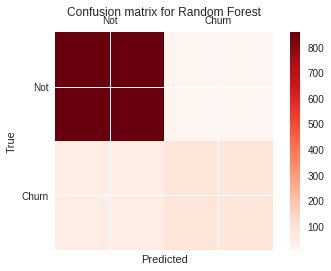

Logistic Regression
Accuracy is: 0.862
precision is: 0.475
recall is: 0.140


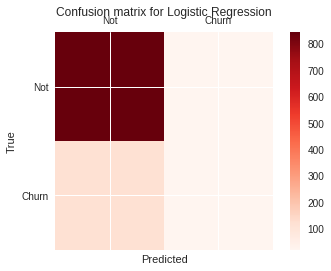

KNN
Accuracy is: 0.905
precision is: 0.825
recall is: 0.382


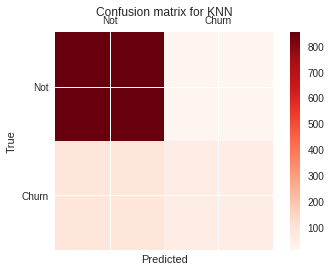

SVC
Accuracy is: 0.923
precision is: 0.883
recall is: 0.500


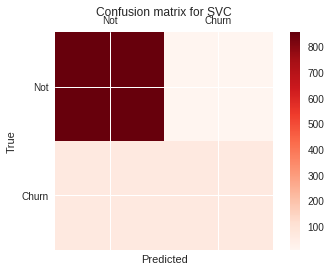

In [0]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("KNN", confusion_matrix(y_test, best_KNN_model.predict(X_test))),
    ("SVC", confusion_matrix(y_test, best_SVC_model.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices)

with LR model the AUC is 0.830567470043573
with RF model the AUC is 0.893901484204793
with KNN model the AUC is 0.8616855596405228


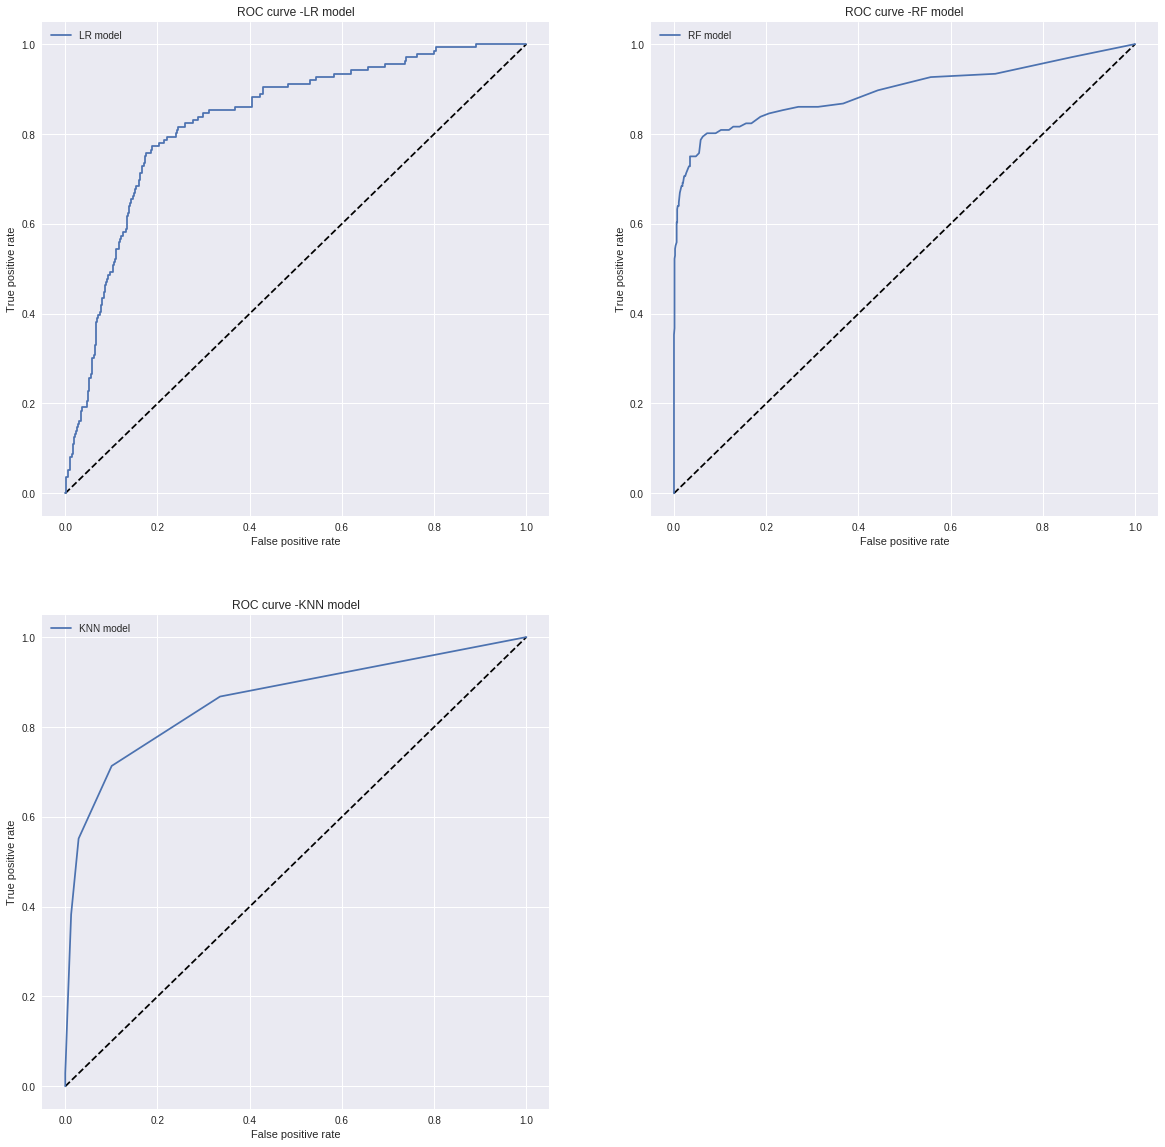

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

best_models = {"LR model": best_LR_model,
               "RF model": best_RF_model,
               "KNN model": best_KNN_model}

nrows = 2
ncols = 2
i = 1
plt.figure(figsize = (20, 20))


for best_model in best_models.keys():

  y_pred_lr = best_models[best_model].predict_proba(X_test)[:, 1]
  fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
  plt.subplot(nrows,ncols, i)
  i += 1
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_lr, tpr_lr, label= best_model)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve -' + best_model)
  plt.legend(loc='best')
  
  print("with", best_model, "the AUC is", metrics.auc(fpr_lr,tpr_lr))


plt.show()

# Step5 : Feature Evaluation

In [0]:
# mainly focus on RF model since it is the best one against all others

importances = best_RF_model.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
total_day_charge: 0.2757
number_customer_service_calls: 0.12
total_eve_charge: 0.1161
intl_plan: 0.0721
total_night_charge: 0.0676
total_intl_minutes: 0.0581
total_intl_charge: 0.056
total_night_calls: 0.0487
account_length: 0.0485
total_day_calls: 0.0472
total_eve_calls: 0.0461
number_vmail_messages: 0.0268
voice_mail_plan: 0.017


# Conclusion:

1. From every aspect (acurracy, precison, recall), Random Forest model performs the best against
among all models I select, including KNN, SVC, and Logistic Regression model. SVC is the second 
best model, but the scores SVC gets is lower than Random Forest. However, one thing noteworthy
is that Random Forest requires longer computation time than the others.

2. the recall rate is relatively much lower than other statistic in each model. The data seems not
balanced in this case that the number of churned consumers is only 14.14% of the population.

3. During feature inspection stage, I have done feature selection to remove 3 extremely highly 
correlated data.

4. There are some ways to improve the model performance: use a more balanced dataset, 
add a larger penalty on recall when training the model. We could also use one hot encoding to 
categorize different states to see if there are some variation in different area. 

5. From Random Forest model, total_day_charge (highly correlated with total_day_minutes) is
the most significant features, number of service calls and total even charge (highly correlated with 
total_even_minutes) are also relatively more important than other features. The company could focus 
on these aspects to prevent loss of consumers.